In [486]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
sns.set()

In [487]:
PATH = "../../Downloads"

In [749]:
df = pd.read_csv(f"{PATH}/London_Gateway_vessels_tmp.csv", parse_dates=['ETA', 'ETD'])
df['target'] = df['ETD'] - df['ETA']
df['target'] = df['target'].dt.total_seconds()

df['year'] = df.ETA.dt.year
df['month'] = df.ETA.dt.month
df['week'] = df.ETA.dt.week
df['day'] = df.ETA.dt.day
df = df.drop(['ETA','ETD'], axis=1)
print(f'London_Gateway_vessels_tmp dataset shape is  {df.shape}')
df.head(3)

London_Gateway_vessels_tmp dataset shape is  (4328, 11)


,Vessel Name,Operator,Service,Phase,Previous port of call,Next port of call,target,year,month,week,day
0,MSC INES,Mediterranean Shipping Company,LEV,DEPARTED,Rotterdam (DDN),Antwerp,42180.0,2020,6,26,27
1,APL CHONGQING,CMA CGM,EPIC,DEPARTED,Le Havre,Hamburg,88680.0,2020,6,26,27
2,BANAK,HAPAG LLOYD,CES,DEPARTED,Kingston,Vlissingen,44640.0,2020,6,26,28


In [750]:
# 用到的字段， 做了EDA选择. 具体为什么可以打电话问我。 最终我选择：
COL = ['Name','Size','Dwt','GT','Built','Eco - Electronic Engine']
ship = pd.read_csv(f"{PATH}/Clarksons_world_containership_fleet_2021.csv", usecols =COL)
ship['Eco - Electronic Engine'] = ship['Eco - Electronic Engine'].fillna('unknown')
ship = ship.dropna()

In [751]:
#一点预处理。  大小写， 数字转换啥的
ship.Name = ship.Name.str.upper()
ship.Size = ship.Size.str.replace(',', '').astype('int')
ship.Dwt = ship.Dwt.str.replace(',', '').astype('int')
ship.GT = ship.GT.str.replace(',', '').astype('int')
ship.Built = ship.Built.astype('int')
ship = ship.rename(columns={'Name':'Vessel Name'})
print(f'ship.shape = {ship.shape}')

ship.shape = (5489, 6)


### 做有个左连接。 因为London_Gateway_vessels_tmp 的船，有一些在Clarksons_world_containership_fleet_2021没见过

In [752]:
df_ship = pd.merge(df, ship, on = 'Vessel Name', how = 'left')
df_ship = df_ship.fillna(method = 'ffill')

In [757]:
df_ship.head(3)

,Vessel Name,Operator,Service,Phase,Previous port of call,Next port of call,target,year,month,week,day,Size,Dwt,GT,Built,Eco - Electronic Engine
0,MSC INES,Mediterranean Shipping Company,LEV,DEPARTED,Rotterdam (DDN),Antwerp,42180.0,2020,6,26,27,9200.0,114732.0,107551.0,2006.0,unknown
1,APL CHONGQING,CMA CGM,EPIC,DEPARTED,Le Havre,Hamburg,88680.0,2020,6,26,27,10106.0,122200.0,113735.0,2011.0,Eco – Electronic Engine
2,BANAK,HAPAG LLOYD,CES,DEPARTED,Kingston,Vlissingen,44640.0,2020,6,26,28,2546.0,34067.0,26374.0,2014.0,Eco – Electronic Engine


# 总体分布

单位为停港口时间（秒）

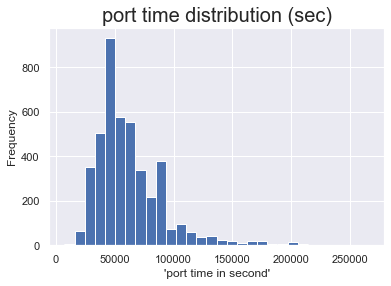

In [753]:
ax = df_ship['target'].plot(kind='hist', bins=30)
ax.set_xlabel("'port time in second'")
_ = ax.set_title('port time distribution (sec)', fontsize=20)

# Operator 是重要影响Target分布的因素

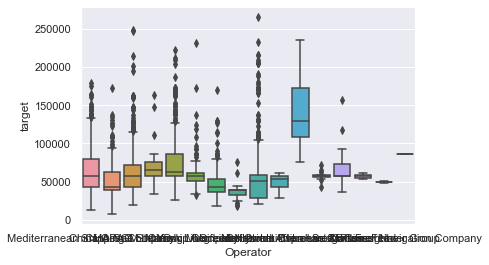

In [712]:
sns.boxplot(x="Operator", y="target", data=df_ship)

# Previous port of call 是重要影响Target分布的因素

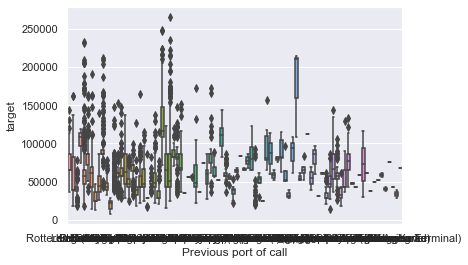

In [713]:
sns.boxplot(x="Previous port of call", y="target", data=df_ship)

# Next port of call 是重要影响Target分布的因素

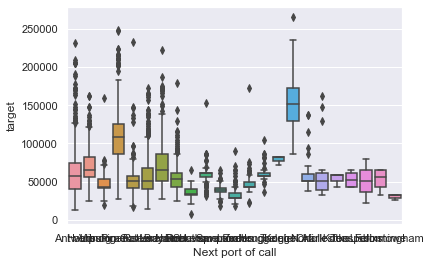

In [714]:
sns.boxplot(x="Next port of call", y="target", data=df)

# Service 是重要影响Target分布的因素

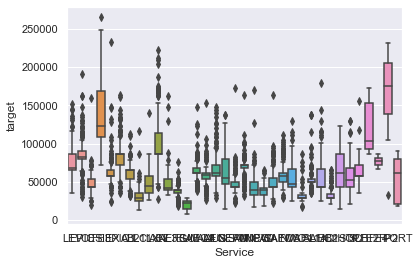

In [715]:
sns.boxplot(x="Service", y="target", data=df_ship)

# 夏季 冬季 停泊时间短于冬季, 夏季分布更为集中。  但实际区别也不是很大

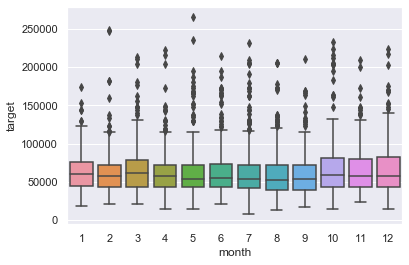

In [716]:
sns.boxplot(x="month", y="target", data=df_ship)

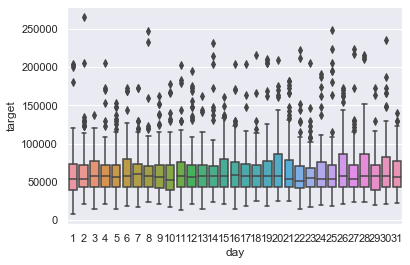

In [754]:
sns.boxplot(x="day", y="target", data=df_ship)

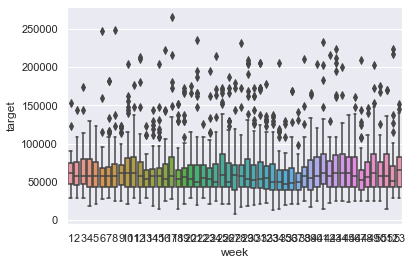

In [755]:
sns.boxplot(x="week", y="target", data=df_ship)

In [717]:
win_sum_diff = pd.concat([df.query('month==1 or month==7')[['month','target']].groupby('month').mean(), 
            df.query('month==1 or month==7')[['month','target']].groupby('month').std()], axis=1)
win_sum_diff.columns = ['mean', 'std']
win_sum_diff

,mean,std
month,,
1,62838.323353,22855.452919
7,61429.193825,31371.092159


# 到港时间 收到Phase影响  区别也不是很大

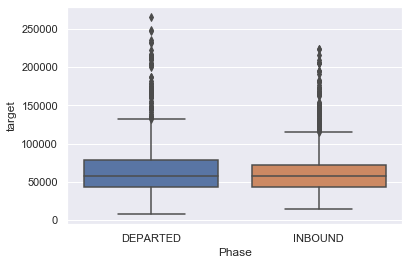

In [718]:
sns.boxplot(x="Phase", y="target", data=df_ship)

In [719]:
phase_diff = pd.concat([df[['Phase','target']].groupby('Phase').mean(), df[['Phase','target']].groupby('Phase').std()], axis=1)
phase_diff.columns = ['mean', 'std']
phase_diff

,mean,std
Phase,,
DEPARTED,66385.183486,36586.672322
INBOUND,61042.947020,26975.222843


# 船的建造年份 和 停港时间关系

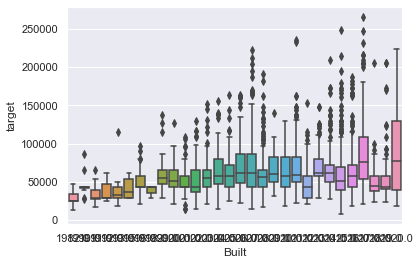

In [723]:
sns.boxplot(x="Built", y="target", data=df_ship)

# 和是不是 Electronic 关系

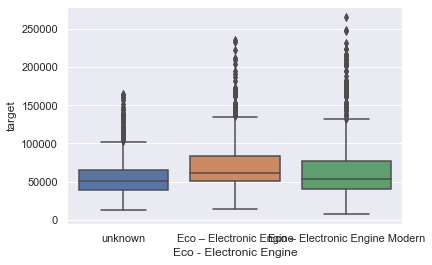

In [725]:
sns.boxplot(x="Eco - Electronic Engine", y="target", data=df_ship)

# 三个数值特征 相关性分析

可见 Dwt 和 Size 强相关。 保留一个就可以。 保留 Size
Built建造年份年份弱相关。 先保留

In [758]:
df_ship[['target','Size','Dwt','Built','GT']].corr()

,target,Size,Dwt,Built,GT
target,1.000000,0.614973,0.595927,0.173515,0.608091
Size,0.614973,1.000000,0.981013,0.338366,0.990880
Dwt,0.595927,0.981013,1.000000,0.330527,0.991081
Built,0.173515,0.338366,0.330527,1.000000,0.323473
GT,0.608091,0.990880,0.991081,0.323473,1.000000


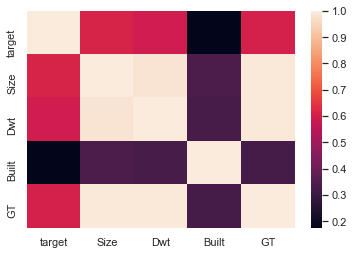

In [759]:
corr = df_ship[['target','Size','Dwt','Built','GT']].corr()
sns.heatmap(corr)

# 最后的最后，我们拿到候选特征

In [756]:
df_ship.columns

Index(['Vessel Name', 'Operator', 'Service', 'Phase', 'Previous port of call',
       'Next port of call', 'target', 'year', 'month', 'week', 'day', 'Size',
       'Dwt', 'GT', 'Built', 'Eco - Electronic Engine'],
      dtype='object')

In [763]:
col_feat_list = ['Operator', 
                 'Service', 
                 'Phase',
                 'Previous port of call',
                 'Next port of call',
                 'Eco - Electronic Engine']

num_feat_list = ['Size','month','week','day', 'Dwt', 'GT', 'Built']

In [764]:
import lightgbm as lgb

In [769]:
X = df_ship[num_feat_list + col_feat_list]
y = df_ship['target']
for col in col_feat_list:
    X[col] = X[col].astype('category')
X.shape, y.shape

/Users/lim/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


((4364, 13), (4364,))

In [770]:
X.head(3)

,Size,month,week,day,Dwt,GT,Built,Operator,Service,Phase,Previous port of call,Next port of call,Eco - Electronic Engine
0,9200.0,6,26,27,114732.0,107551.0,2006.0,Mediterranean Shipping Company,LEV,DEPARTED,Rotterdam (DDN),Antwerp,unknown
1,10106.0,6,26,27,122200.0,113735.0,2011.0,CMA CGM,EPIC,DEPARTED,Le Havre,Hamburg,Eco – Electronic Engine
2,2546.0,6,26,28,34067.0,26374.0,2014.0,HAPAG LLOYD,CES,DEPARTED,Kingston,Vlissingen,Eco – Electronic Engine


In [771]:
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)

In [772]:
lg_reg = gbm.fit(X, y)

In [773]:
lg_prediction = lg_reg.predict(X)

In [774]:
lg_residual = lg_prediction - y
lg_residual.mean(), lg_residual.std()

(31.481287582307726, 20141.63050146461)

# 残差分析 Residual analysis

### 1.  残差分布（秒）

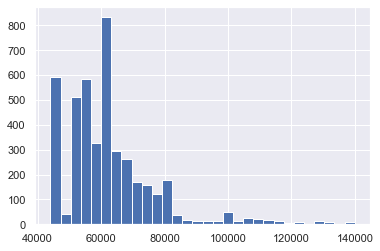

In [775]:
_ = plt.hist(lg_prediction, bins=30)

### 2. 停泊时间分布（秒）

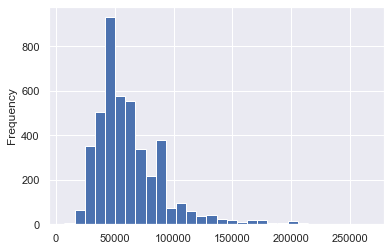

In [776]:
y.plot(kind='hist', bins=30)

In [777]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 几个重要的 Metric

In [778]:
r2_score(y,lg_prediction)

0.5560796920977382

其实还行了 $R^2$ 达到55.6% 已经算是一个还可以用的baseline model

In [779]:
mean_absolute_error(y,lg_prediction)

13715.029292853858

In [780]:
mean_squared_error(y,lg_prediction)

405593308.5326506

# Cross validation

In [742]:
from sklearn.model_selection import cross_val_score

In [781]:
scores = cross_val_score(lg_reg, X, y, cv = 10, scoring='r2')
scores

array([0.46592791, 0.54851519, 0.46715113, 0.44773322, 0.51880608,
       0.53432459, 0.5748912 , 0.51636214, 0.52803399, 0.32466602])

In [782]:
scores = cross_val_score(lg_reg, X, y, cv = 10, scoring='neg_mean_absolute_error')
scores

array([-14400.13655302, -13525.29369015, -15113.31739315, -15263.34211301,
       -12799.03299651, -12687.7782855 , -12809.65246798, -14852.93782736,
       -15279.1038795 , -18441.77145834])

# 下一步 走向神经网络 

In [789]:
# 统计一下唯一的值， 看看可否 one-hot encoding
for col in col_feat_list:
    print(col, len(X[col].unique()))

Operator 16
Service 35
Phase 2
Previous port of call 90
Next port of call 23
Eco - Electronic Engine 3
